引力波与暗物质晕交互可视化

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18  # FlatLambdaCDM, FLRW cosmology with a cosmological constant and no curvature

In [ ]:
# set up other cosmological parameters
z_range = np.linspace(0.1,3,100)
comoving_dist = Planck18.comoving_distance(z_range)

# Distribution of dark matter halo
mass_halo = 1e12 * (1 + z_range)**2.5  # mass-z relation
density_profile = mass_halo / (4/3*np.pi*(100*3.086e21)**3)  # ~100kpc
# visualize
fig, ax = plt.subplots(figsize=(15,10))
im = ax.scatter(comoving_dist, np.zeros_like(z_range), c=density_profile, 
                cmap='viridis', s=mass_halo/1e11, alpha=0.6)
# GW path
wave_path = ax.plot(comoving_dist, 0.1*np.sin(10*comoving_dist.value), 
                    lw=2, color='cyan', label='GW path')

# 相位偏移
for z, d in zip(z_range[::10], comoving_dist[::10]):
    phase_shift = 1e-3 * (1 + z)**2  # 相位偏移模型
    ax.annotate(f'ΔΦ={phase_shift:.1e} rad', (d.value, 0), 
                rotation=45, fontsize=8)
plt.colorbar(im, label='Dark Matter Density (M⊙/pc³)')
ax.set_xlabel('Comoving Distance (Mpc)')
ax.set_title('GW Propagation through Dark Matter Halos')
plt.savefig('GW_lensing.png', dpi=300)

现有算法下双黑洞并合的SNR计算（可用于误报率计算）

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from pycbc.noise import gaussian
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.filter import matched_filter
from pycbc.types import TimeSeries
from astropy.cosmology import Planck15 as cosmo

# 设置参数范围
total_mass_range = np.linspace(20, 100, 5)       # 太阳质量
q_range = np.linspace(1, 8, 5)                   # 质量比 q = m1/m2
z_range = np.linspace(0.3, 1.5, 4)               # 红移

# 设置采样率与数据长度
sample_rate = 4096
delta_t = 1.0 / sample_rate
data_len = 8      # 秒数
n_samples = int(data_len * sample_rate)

# 生成 PSD
psd = aLIGOZeroDetHighPower(n_samples//2 + 1, delta_f=1.0/data_len, low_freq_cutoff=20.0)

# 输出结果列表
results = []

for M in total_mass_range:
    for q in q_range:
        m1 = M * q / (1 + q)
        m2 = M / (1 + q)
        for z in z_range:
            # 计算红移距离
            dL = cosmo.luminosity_distance(z).to('Mpc').value

            # 生成波形（仅+极化）
            hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
                                     mass1=m1, mass2=m2,
                                     distance=dL,
                                     inclination=0.0,
                                     delta_t=delta_t,
                                     f_lower=20.0)

            # 将波形裁剪为指定长度，并归一到数据长度
            hp = hp.crop(1, 1)
            hp.resize(n_samples)

            # 生成模拟噪声数据
            noise = gaussian.noise_from_psd(n_samples, delta_t, psd, seed=127)

            # 注入信号
            signal = noise.copy()
            signal.data += hp.data

            # 匹配滤波
            snr = matched_filter(hp, signal, psd=psd,
                                 low_frequency_cutoff=20.0)

            peak_snr = abs(snr).numpy().max()
            results.append((m1, m2, z, peak_snr))

            print(f"m1={m1:.1f}, m2={m2:.1f}, z={z:.2f}, SNR={peak_snr:.2f}") # 误报率的

基于Python的累积相位偏移建模

Sheth-Tormen晕函数和milli-Millennium数据联合修正暗物质参数

In [1]:
from IPython.display import FileLink

 正在处理 z = 0.1
 正在处理 z = 0.5
 正在处理 z = 1.0
 正在处理 z = 1.5
 正在处理 z = 2.0
 正在处理 z = 2.5
 正在处理 z = 3.0
 合成多红移 HMF 保存为：combined_hmf_outputs/combined_hmf_all_z.npz


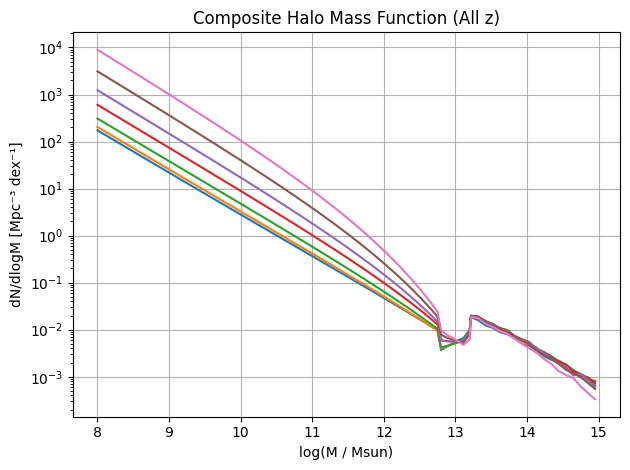

In [2]:
from hmf import MassFunction
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os

# ----------------- Config -------------------
hmf_model = 'SMT'
join_mass = 1e13  # M_sun/h，拼接质量点
z_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
snap_to_z = {58: 0.1, 48: 0.5, 40: 1.0, 38: 1.5, 34: 2.0, 32: 2.5, 28: 3.0}
z_to_snap = {v: k for k, v in snap_to_z.items()}
input_npz_path = "halo_mass_function_fixed.npz"
output_dir = "combined_hmf_outputs"
os.makedirs(output_dir, exist_ok=True)

sim_data = np.load(input_npz_path)
mass_bins = sim_data['mass_bins']
mass_centers = 0.5 * (mass_bins[:-1] + mass_bins[1:])
log_mass_sim = np.log10(mass_centers)

npz_output = {'z_list': np.array(z_list)}
final_logM = None

for z in z_list:
    print(f" 正在处理 z = {z}")

    # === 1. ST 低质量段 ===
    mf = MassFunction(z=z, Mmin=8, Mmax=np.log10(join_mass), dlog10m=0.05, hmf_model=hmf_model)
    M_st = mf.m
    logM_st = np.log10(M_st)
    dndlogM_st = mf.dndlog10m  # 已是 Mpc^-3 dex^-1

    # === 2. 模拟数据高质量段 ===
    snap = z_to_snap[z]
    key = f'dn_dlogM_snap{snap}'
    dndlogM_sim = sim_data[key]
    mask_sim = mass_centers >= join_mass
    logM_sim = np.log10(mass_centers[mask_sim])
    dndlogM_sim = dndlogM_sim[mask_sim]

    # === 3. 对 ST 部分进行归一化（匹配拼接点）
    join_logM = np.log10(join_mass)
    st_interp = interp1d(logM_st, dndlogM_st, kind='linear', fill_value='extrapolate')
    sim_interp = interp1d(logM_sim, dndlogM_sim, kind='linear', fill_value='extrapolate')

    scale_factor = sim_interp(join_logM) / st_interp(join_logM)
    dndlogM_st_scaled = dndlogM_st * scale_factor

    # === 4. 平滑拼接区 ±0.2 dex
    overlap_low = join_logM - 0.2
    overlap_high = join_logM + 0.2
    overlap_logM = np.linspace(overlap_low, overlap_high, 10)

    st_scaled_interp = interp1d(logM_st, dndlogM_st_scaled, kind='linear', fill_value='extrapolate')
    sim_interp = interp1d(logM_sim, dndlogM_sim, kind='linear', fill_value='extrapolate')

    overlap_dndlogM = 0.5 * (st_scaled_interp(overlap_logM) + sim_interp(overlap_logM))

    # === 5. 拼接三段
    logM_final = np.concatenate([
        logM_st[logM_st < overlap_low],
        overlap_logM,
        logM_sim[logM_sim > overlap_high]
    ])
    dndlogM_final = np.concatenate([
        dndlogM_st_scaled[logM_st < overlap_low],
        overlap_dndlogM,
        dndlogM_sim[logM_sim > overlap_high]
    ])

    if final_logM is None:
        final_logM = logM_final
        npz_output['logM_bins'] = final_logM
    else:
        interp_final = interp1d(logM_final, dndlogM_final, bounds_error=False, fill_value=0.0)
        dndlogM_final = interp_final(final_logM)

    z_key = f'dN_dlogM_z{str(z).replace(".", "p")}'
    npz_output[z_key] = dndlogM_final

    df = pd.DataFrame({'logM': final_logM, 'dN_dlogM': dndlogM_final})
    df.to_csv(f"{output_dir}/combined_hmf_z{str(z).replace('.', 'p')}.csv", index=False)
    plt.plot(final_logM, dndlogM_final, label=f'z={z}')

np.savez(f"{output_dir}/combined_hmf_all_z.npz", **npz_output)
print(f" 合成多红移 HMF 保存为：{output_dir}/combined_hmf_all_z.npz")

plt.yscale('log')
plt.xlabel('log(M / Msun)')
plt.ylabel('dN/dlogM [Mpc⁻³ dex⁻¹]')
plt.title('Composite Halo Mass Function (All z)')
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{output_dir}/combined_hmf_all_z.png", dpi=300)
plt.show()

模型构建

In [3]:
import numpy as np
from scipy.constants import G, c
from scipy.integrate import simpson
from astropy.cosmology import Planck15 as cosmo

def compute_shapiro_delay(logM_bins, dNdlogM, z, r_mpc=0.0001):
    M_vals = 10**logM_bins * 1.989e30  # 转换为 kg
    phi_vals = -G * M_vals / (r_mpc * 3.08567758e22)
    integrand = -2 * phi_vals * dNdlogM / c**3
    delay_per_mpc = simpson(integrand, logM_bins) * 100   #  
    D = cosmo.comoving_distance(z).value
    return delay_per_mpc * D  # 单位：秒

def compute_wave_optics_delay(logM_bins, dNdlogM, frequency, kappa0=0.01, M0=1e10, f0=100, beta=0.6, gamma=1.2):
    """
    计算波光学调制项，低质量晕贡献主导，频率增强
    """
    M_vals = 10**logM_bins
    kappa_vals = kappa0 * (M_vals / M0)**(-beta) * (frequency / f0)**gamma
    integrand = kappa_vals * dNdlogM
    delay_wave = simpson(integrand, logM_bins)
    return delay_wave / 1e7  

def compute_density_perturbation(tau_shapiro, alpha=0.3, sigma=0.2):
    """
    使用高斯扰动乘以主项模拟宇宙纤维引起的路径扰动
    """
    random_factor = np.random.normal(loc=0.0, scale=sigma)
    return alpha * random_factor * tau_shapiro

def compute_total_lens_delay(logM_bins, dNdlogM, z, frequency=100):
    tau_shapiro = compute_shapiro_delay(logM_bins, dNdlogM, z)
    tau_wave = compute_wave_optics_delay(logM_bins, dNdlogM, frequency)
    tau_density = compute_density_perturbation(tau_shapiro)
    tau_total = tau_shapiro + tau_wave + tau_density
    total_phase_shift = 2 * np.pi * frequency * tau_total
    return {
        "tau_shapiro": tau_shapiro,
        "tau_wave": tau_wave,
        "tau_density": tau_density,
        "tau_total": tau_total,
        "total_phase_shift": total_phase_shift
    }


In [6]:
import numpy as np
data = np.load("combined_hmf_all_z.npz")
print("Keys in file:", data.files)
key = data.files[0]
print(f"Shape of {key}:", data[key].shape)
print(f"Sample values of {key}:", data[key][:5])

Keys in file: ['z_list', 'logM_bins', 'dN_dlogM_z0p1', 'dN_dlogM_z0p5', 'dN_dlogM_z1p0', 'dN_dlogM_z1p5', 'dN_dlogM_z2p0', 'dN_dlogM_z2p5', 'dN_dlogM_z3p0']
Shape of z_list: (7,)
Sample values of z_list: [0.1 0.5 1.  1.5 2. ]


In [7]:
logM_bins = data['logM_bins']
dNdlogM = data['dN_dlogM_z1p0']
z = 1.0
f = 150 
results = compute_total_lens_delay(logM_bins, dNdlogM, z, frequency=f)
for key, val in results.items():
    print(f"{key}: {val:.3e} s")

tau_shapiro: 1.297e-06 s
tau_wave: 2.292e-06 s
tau_density: -1.055e-07 s
tau_total: 3.484e-06 s
total_phase_shift: 3.283e-03 s


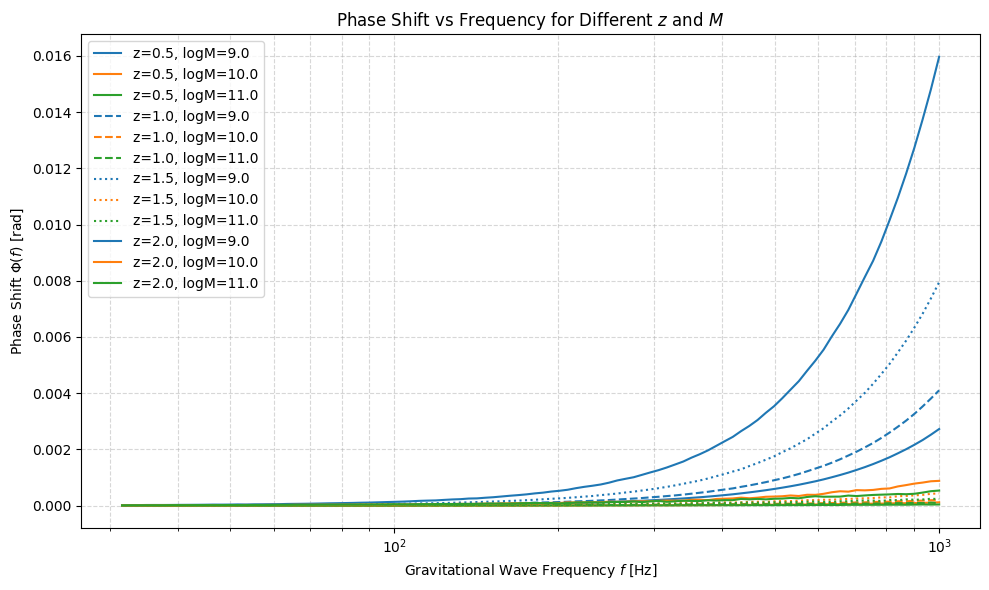

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# compute_total_lens_delay, logM_bins, data, etc.

frequencies = np.logspace(1.5, 3, 100)  # 30Hz 到 1000Hz
z_list = [0.5, 1.0, 1.5, 2.0]
mass_filters = [9.0, 10.0, 11.0]  # log10(M)

colors = ['tab:blue', 'tab:orange', 'tab:green']
linestyles = ['-', '--', ':']

plt.figure(figsize=(10, 6))

for i, z in enumerate(z_list):
    dNdlogM = data[f'dN_dlogM_z{str(z).replace(".", "p")}']
    for j, logM_ref in enumerate(mass_filters):
        weight = np.exp(-0.5 * ((logM_bins - logM_ref) / 0.1)**2)
        dNdlogM_filtered = dNdlogM * weight

        phase_shifts = []
        for f in frequencies:
            tau = compute_total_lens_delay(logM_bins, dNdlogM_filtered, z, frequency=f)["tau_total"]
            phi = 2 * np.pi * f * tau
            phase_shifts.append(phi)

        label = f"z={z}, logM={logM_ref}"
        plt.plot(frequencies, phase_shifts, label=label,
                 color=colors[j], linestyle=linestyles[i % len(linestyles)])

plt.xscale('log')
plt.xlabel('Gravitational Wave Frequency $f$ [Hz]')
plt.ylabel('Phase Shift $\\Phi(f)$ [rad]')
plt.title('Phase Shift vs Frequency for Different $z$ and $M$')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('相位偏移-频率曲线.png', dpi=300)
plt.show()

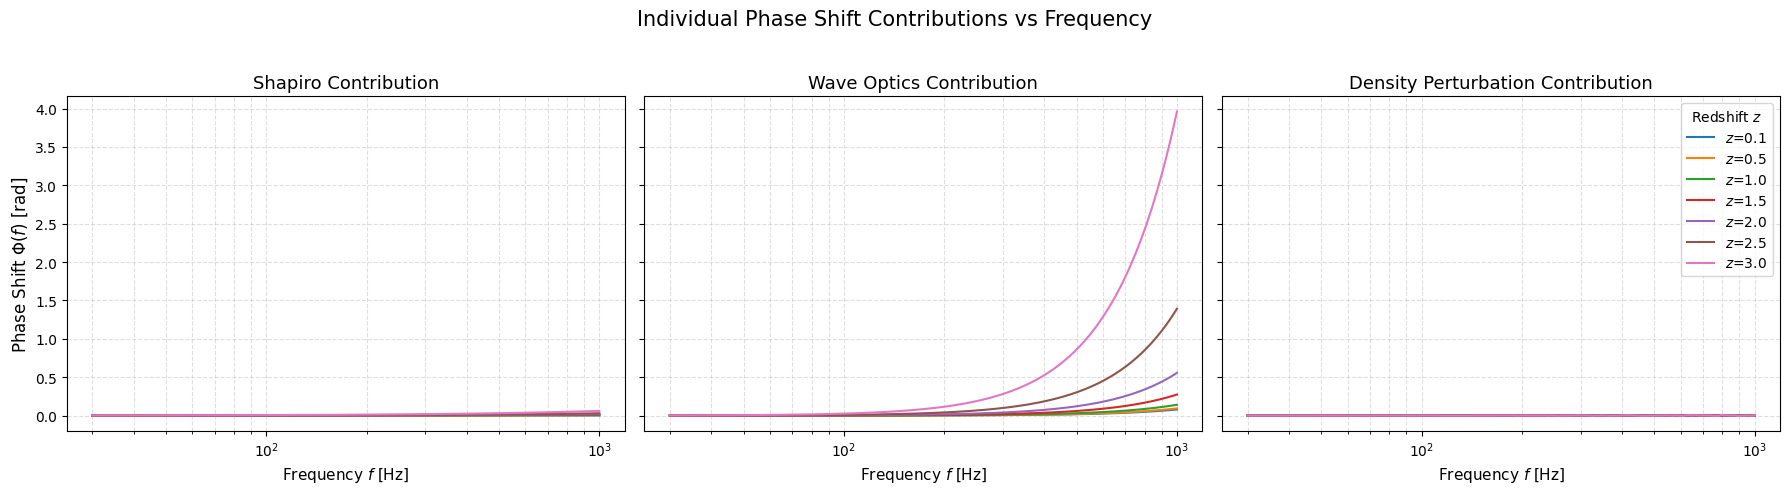

In [8]:
import numpy as np
import matplotlib.pyplot as plt

frequencies = np.logspace(np.log10(30), 3, 200)  # 30Hz ~ 1000Hz
z_list = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# 初始化
results_phi = {
    "shapiro": {z: [] for z in z_list},
    "wave": {z: [] for z in z_list},
    "density": {z: [] for z in z_list}
}

for z in z_list:
    dNdlogM = data[f'dN_dlogM_z{str(z).replace(".", "p")}']
    for f in frequencies:
        τs = compute_total_lens_delay(logM_bins, dNdlogM, z, frequency=f)
        results_phi["shapiro"][z].append(2 * np.pi * f * τs["tau_shapiro"])
        results_phi["wave"][z].append(2 * np.pi * f * τs["tau_wave"])
        results_phi["density"][z].append(2 * np.pi * f * τs["tau_density"])

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
contributions = ["shapiro", "wave", "density"]
titles = [
    "Shapiro Contribution",
    "Wave Optics Contribution",
    "Density Perturbation Contribution"
]

for i, ax in enumerate(axes):
    contrib = contributions[i]
    for z in z_list:
        ax.plot(frequencies, results_phi[contrib][z], label=f"$z$={z}")
    ax.set_xscale('log')
    ax.set_xlabel("Frequency $f$ [Hz]", fontsize=11)
    ax.set_title(titles[i], fontsize=13)
    ax.grid(True, which='both', ls='--', alpha=0.4)
    if i == 0:
        ax.set_ylabel("Phase Shift $\\Phi(f)$ [rad]", fontsize=12)

axes[2].legend(title="Redshift $z$")
plt.suptitle("Individual Phase Shift Contributions vs Frequency", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('各项贡献对比.png', dpi=300)
plt.show()

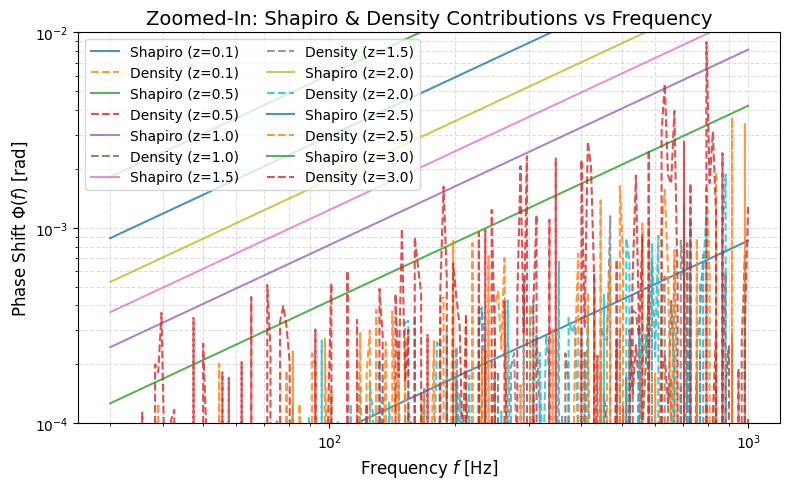

In [9]:
# 只对 Shapiro 和 Density 项进行对比
plt.figure(figsize=(8, 5))
for z in z_list:
    phi_shapiro = np.array(results_phi["shapiro"][z])
    phi_density = np.array(results_phi["density"][z])
    
    plt.plot(frequencies, phi_shapiro, linestyle='-', label=f"Shapiro (z={z})", alpha=0.8)
    plt.plot(frequencies, phi_density, linestyle='--', label=f"Density (z={z})", alpha=0.8)

plt.xscale('log')
plt.yscale('log')  
plt.xlabel("Frequency $f$ [Hz]", fontsize=12)
plt.ylabel("Phase Shift $\\Phi(f)$ [rad]", fontsize=12)
plt.title("Zoomed-In: Shapiro & Density Contributions vs Frequency", fontsize=14)
plt.ylim(1e-4, 1e-2)  
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend(ncol=2, fontsize=10)
plt.tight_layout()
plt.savefig('Shapiro和非均匀密度扰动项的贡献.png', dpi=300)
plt.show()

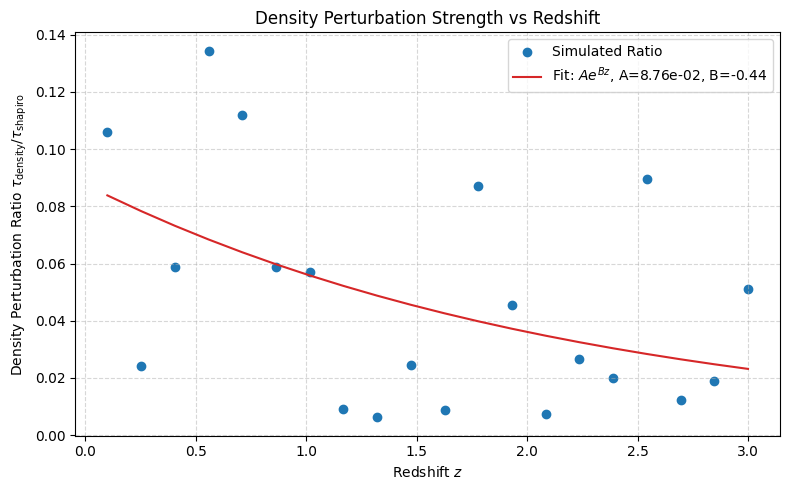

In [10]:
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt

# 构建更密集的红移样本
z_dense = np.linspace(0.1, 3.0, 20)

# 为每个 z 拟合或插值 dN/dlogM（使用 z=0.1~3.0 的现有 7 组数据）
z_keys = np.array([0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
dNdlogMs = np.array([data[f'dN_dlogM_z{str(z).replace(".", "p")}'] for z in z_keys])
interp_func = interp1d(z_keys, dNdlogMs, axis=0, kind='linear', fill_value="extrapolate")

# 计算扰动比例
ratios = []
comoving_distances = []

np.random.seed(0)
for z in z_dense:
    dNdlogM_interp = interp_func(z)
    τs = compute_total_lens_delay(logM_bins, dNdlogM_interp, z, frequency=100)
    ratio = np.abs(τs["tau_density"] / τs["tau_shapiro"])
    ratios.append(ratio)
    comoving_distances.append(cosmo.comoving_distance(z).value)

ratios = np.array(ratios)
comoving_distances = np.array(comoving_distances)

# 拟合指数函数：y = A * exp(B * z)
def model(z, A, B):
    return A * np.exp(B * z)

popt, _ = curve_fit(model, z_dense, ratios, p0=[0.1, 1.0])
fit_y = model(z_dense, *popt)

plt.figure(figsize=(8, 5))
plt.scatter(z_dense, ratios, label="Simulated Ratio", color='tab:blue')
plt.plot(z_dense, fit_y, label=f"Fit: $A e^{{Bz}}$, A={popt[0]:.2e}, B={popt[1]:.2f}", color='tab:red')
plt.xlabel("Redshift $z$")
plt.ylabel("Density Perturbation Ratio $\\tau_{\\rm density}/\\tau_{\\rm shapiro}$")
plt.title("Density Perturbation Strength vs Redshift")
plt.grid(True, ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('扰动强度-共动距离.png', dpi=300)
plt.show()

波形修正

In [36]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
from pycbc.waveform import get_fd_waveform
import matplotlib.pyplot as plt

def generate_lensed_imrphenomp(mass1, mass2, f_low, delta_f, z, dNdlogM, logM_bins, f_high=1024):
    """
    参数:
        mass1, mass2: 双黑洞质量（单位：Msun）
        f_low, delta_f: 最低频率与频率分辨率（Hz）
        z: 红移
        dNdlogM, logM_bins: 暗物质分布数据
    返回:
        f, h_lensed: 频率数组 与 透镜修正波形
    """
    hp, _ = get_fd_waveform(approximant="IMRPhenomPv2",
                            mass1=mass1, mass2=mass2,
                            delta_f=delta_f, f_lower=f_low, f_final=f_high,
                            distance=500, inclination=0, coa_phase=0)

    f = hp.sample_frequencies.numpy()  
    h_unlensed = hp.numpy()

    phase_shift = np.zeros_like(f)
    for i, freq in enumerate(f):
        τ = compute_total_lens_delay(logM_bins, dNdlogM, z, frequency=freq)["tau_total"]
        phase_shift[i] = 2 * np.pi * freq * τ

    h_lensed = h_unlensed * np.exp(1j * phase_shift)
    return f, h_unlensed, h_lensed

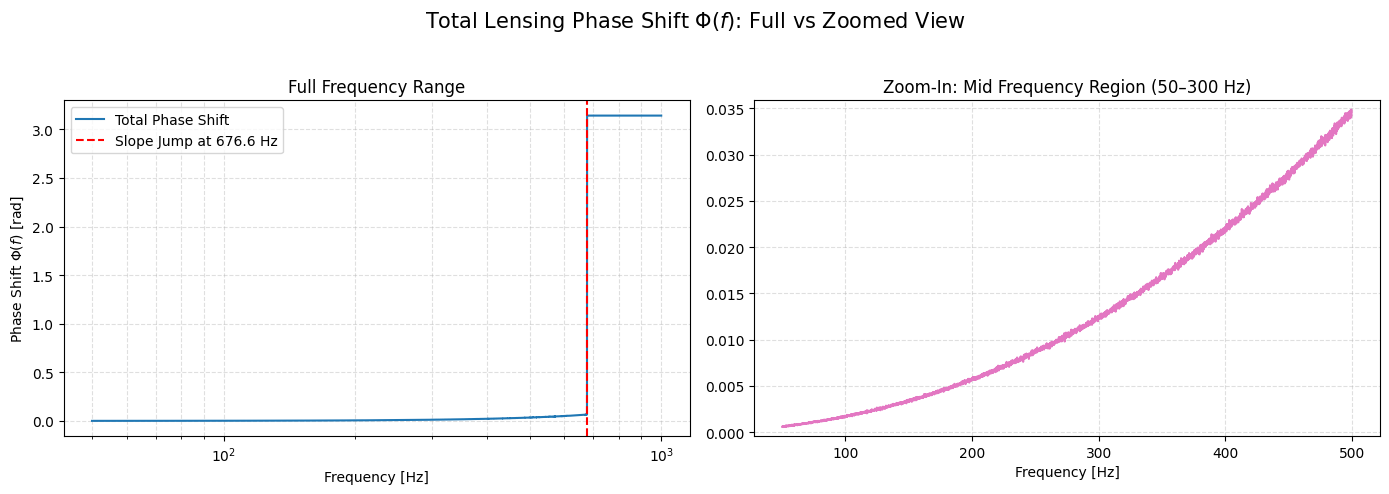

In [18]:
z = 1.0
logM_bins = data['logM_bins']
dNdlogM = data['dN_dlogM_z1p0']
f, h0, h1 = generate_lensed_imrphenomp(mass1=30, mass2=30,
                                       f_low=30, delta_f=0.1,
                                       z=z, dNdlogM=dNdlogM, logM_bins=logM_bins)

phase_shift_total = np.unwrap(np.angle(h1) - np.angle(h0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

dphi_df = np.gradient(phase_shift_total, f)
max_grad_idx = np.argmax(dphi_df)
f_jump = f[max_grad_idx]
phi_jump = phase_shift_total[max_grad_idx]

# 全部频段
full_mask = (f >= 50) & (f <= 1000)
f_full = f[full_mask]
phi_full = phase_shift_total[full_mask]
ax1.plot(f_full, phi_full, label="Total Phase Shift")
ax1.axvline(f_jump, color='red', linestyle='--', label=f"Slope Jump at {f_jump:.1f} Hz")
ax1.set_xscale("log")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Phase Shift $\\Phi(f)$ [rad]")
ax1.set_title("Full Frequency Range")
ax1.grid(True, which='both', ls='--', alpha=0.4)
ax1.legend()

# 中频段 zoom in
mid_mask = (f > 50) & (f < 500)
f_mid = f[mid_mask]
phi_mid = phase_shift_total[mid_mask]
ax2.plot(f_mid, phi_mid, color='tab:pink')
ax2.set_xlabel("Frequency [Hz]")
ax2.set_title("Zoom-In: Mid Frequency Region (50–300 Hz)")
ax2.grid(True, which='both', ls='--', alpha=0.4)
ax2.set_ylim(min(phi_mid) - 0.001, max(phi_mid) + 0.001)  # 调整Y轴，使变化可见

plt.suptitle("Total Lensing Phase Shift $\\Phi(f)$: Full vs Zoomed View", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('修正前后波形相位差.png', dpi=300)
plt.show()

In [37]:
def compute_waveform_correlation(h0, h1, df, psd=None):
    """
    参数:
        df: 频率分辨率
        psd: 设为全1（白噪声）
    返回:
        C_f: 点频相干性数组
        rho: 整体归一相关系数
    """
    if psd is None:
        psd = np.ones_like(h0)

    # 点频相干性
    C_f = np.abs(h0.conj() * h1) / (np.abs(h0) * np.abs(h1) + 1e-20)  # 避免除以0

    # 归一化整体相干性
    num = 4 * np.sum((h0.conj() * h1 / psd).real) * df
    den_a = 4 * np.sum((np.abs(h0)**2 / psd).real) * df
    den_b = 4 * np.sum((np.abs(h1)**2 / psd).real) * df
    rho = num / np.sqrt(den_a * den_b)

    return C_f, rho

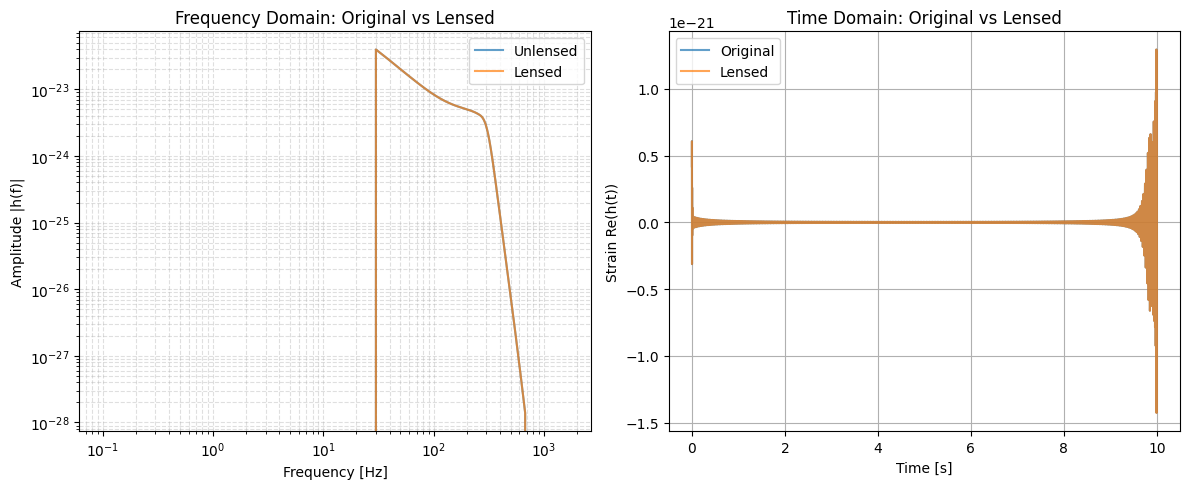

In [35]:
mass1, mass2 = 30, 30
f_low, delta_f = 30, 0.1
z = 1.0

# 生成波形并绘图
f, h_unlensed, h_lensed = generate_lensed_imrphenomp(mass1, mass2, f_low, delta_f, z, dNdlogM, logM_bins)
plot_fd_td_waveform_comparison(f, h_unlensed, h_lensed, delta_f)